# Capstone 1 Statistical Data Analysis
## Predicting Prediabetes with Machine Learning
## NHANES Data 2007-2016

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Load data

dtype_dict = {'SEQN': int}
demo_dtype_dict = {"SEQN": int, "SDDSRVYR": int, "RIDSTATR": int, "RIAGENDR": int, "RIDAGEYR": int, 
                   "RIDRETH1": int, "DMDHHSIZ": int, "DMDFMSIZ": int, 
                   "DMDHRGND": int, "DMDHRAGE": int, "SDMVPSU": int, "SDMVSTRA": int}
ques_dtype_dict = {"SEQN": int, "SMDUPCA": object, "SMD100BR": object}

demo = pd.read_csv('data/demo_all.csv', dtype=demo_dtype_dict)
diet = pd.read_csv('data/diet_all.csv', dtype=dtype_dict)
exam = pd.read_csv('data/exam_all.csv', dtype=dtype_dict)
labs = pd.read_csv('data/labs_all.csv', dtype=dtype_dict)
meds = pd.read_csv('data/meds_all.csv', dtype=dtype_dict)
ques = pd.read_csv('data/questionnaire_all.csv', dtype=ques_dtype_dict)

In [3]:
def set_diab(row):
    """
    Return integer indicator for diabetes diagnosis criteria or NaN if no test results found.
        2 = Diabetes
        1 = Prediabetes
        0 = No Diabetes
        NaN = No test results found
        
    Input: row from labs table including three diagnostics tests for diabetes: 
               LBXGH: Fasting Plasma Glucose, 
               LBXGLU: Glycohemoglobin (HbA1c),
               LBXGLT: Oral Glucose Tolerance Test
    """
    if (np.isnan(row['LBXGH']) and np.isnan(row['LBXGLU']) and np.isnan(row['LBXGLT'])):
        return np.NaN
    # Use American Diabetes Association's diagnosis criteria. 
    if (row['LBXGH'] >= 6.5) or (row['LBXGLU'] >= 126) or (row['LBXGLT'] >= 200):
        return 2
    elif (row['LBXGH'] >= 5.7 or row['LBXGLU'] >= 100 or row['LBXGLT'] >= 140):
        return 1
    else:
        return 0


labs = labs.assign(DIAB=labs.apply(set_diab, axis=1))
labs.DIAB.value_counts()

0.0    17476
1.0    10939
2.0     4087
Name: DIAB, dtype: int64

## Investigate the null hypotheses that the means of various laboratory test results and physical exam markers are the same regardless of diabetes diagnosis indicator.  

We have already shown in the EDA notebook that the three lab tests used to diagnose diabetes and prediabetes are moderately to strongly correlated to each other. We also know that there is an upward trend of at least one of those tests with age. Let us now focus on several risk factors for and side effects of diabetes published in the literature and explore whether or not this data reflects a relationship between those risk factors/side effects and meeting diagnostic criteria for prediabetes and diabetes.

## Look at gender, diagnosed hypertension, moderate activity, and marital status categorical markers. 

### Test 1:
> __$H_{0}$: There is no statistically significant relationship between gender and diabetes diagnosis.__  
> __$H_{a}$: There is a statistically significant relationship between gender and diabetes diagnosis.__

In [4]:
labs_demo = labs.merge(demo, on='SEQN')
gender_diab_test = labs_demo[['RIAGENDR', 'DIAB']].dropna(how='any')
gender_diab_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32502 entries, 0 to 41442
Data columns (total 2 columns):
RIAGENDR    32502 non-null int32
DIAB        32502 non-null float64
dtypes: float64(1), int32(1)
memory usage: 634.8 KB


Gender: 1=Male, 2=Female; Diabetes Indicator: 0=No Diabetes, 1=Prediabetes, 2=Diabetes

In [5]:
contingency_table = pd.crosstab(
    gender_diab_test['RIAGENDR'],
    gender_diab_test['DIAB'],
    margins=True, 
    rownames=['Gender'],
    colnames=['Diabetes Indicator']
)
contingency_table

Diabetes Indicator,0.0,1.0,2.0,All
Gender,,,,
1,8065,5704,2181,15950
2,9411,5235,1906,16552
All,17476,10939,4087,32502


We will use the chi-square test for independence for this data. The data is a good fit in several aspects, except that it is not from a simple, random sample. It is from a complex survey sample. It will still be interesting to see what the data looks like and what results we get despite the sample complexity. 

This data meets several criteria for a good fit for a chi-square test as we have two categorical variables from one sample (NHANES), the  categories are mutually exclusive so there is no overlap, and all frequencies are greater than 5 in our contingency table. Let's visualize the data before running the chi-square test.

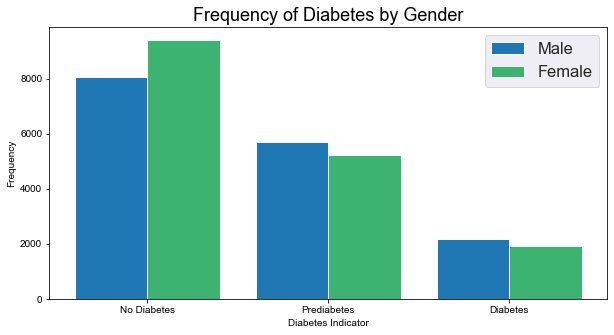

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale=1.5)

malecount = contingency_table.iloc[0][0:3].values
femalecount = contingency_table.iloc[1][0:3].values

categories = ["No Diabetes","Prediabetes","Diabetes"]
x = np.arange(len(categories))

bar_width = 0.4
b1 = ax.bar(x, malecount, 
            width=bar_width, label='Male')
b2 = ax.bar(x + bar_width, femalecount, 
            width=bar_width, label='Female', color='mediumseagreen')

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(categories)

# Label the plot.
plt.legend()
ax.set_title('Frequency of Diabetes by Gender')
ax.set_xlabel('Diabetes Indicator')
ax.set_ylabel('Frequency')
plt.show()

__Now run the chi-square test.__

In [7]:
f_obs = np.array([contingency_table.iloc[0][0:3].values,
                  contingency_table.iloc[1][0:3].values])
f_obs

array([[8065, 5704, 2181],
       [9411, 5235, 1906]], dtype=int64)

In [51]:
chi2, p, dof, expected = stats.chi2_contingency(f_obs)
print('chi-square statistic = ',chi2, '\np-value = ', p, '\ndegrees of freedom = ', dof, '\nexpected values = ', expected)

chi-square statistic =  131.17535293718925 
p-value =  3.2781893031183385e-29 
degrees of freedom =  2 
expected values =  [[8576.15531352 5368.19426497 2005.65042151]
 [8899.84468648 5570.80573503 2081.34957849]]


__Our $\chi^{2}$ value is very large, and our p-value is near zero ($10^{-29}$). We have evidence against the null hypothesis, and therefore choose the alternate hypothesis that gender and diabetes indicator are related somehow.__

### Test 2:
> __$H_{0}$: There is no statistically significant relationship between diagnosed hypertension and diabetes diagnosis.__  
> __$H_{a}$: There is a statistically significant relationship between diagnosed hypertension and diabetes diagnosis.__  

In [9]:
labs_ques = labs.merge(ques, on='SEQN')
bp_diab_test = labs_ques[['BPQ020', 'DIAB']].dropna(how='any')
bp_diab_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29593 entries, 0 to 41442
Data columns (total 2 columns):
BPQ020    29593 non-null float64
DIAB      29593 non-null float64
dtypes: float64(2)
memory usage: 693.6 KB


Hypertension Diagnosis: 1=Yes, 2=No, 7=Refused, 9=Don't know; Diabetes Indicator: 0=No Diabetes, 1=Prediabetes, 2=Diabetes

In [10]:
contingency_table_2 = pd.crosstab(
    bp_diab_test['BPQ020'],
    bp_diab_test['DIAB'],
    margins=True, 
    rownames=['Hypertension Diagnosis'],
    colnames=['Diabetes Indicator']
)
contingency_table_2

Diabetes Indicator,0.0,1.0,2.0,All
Hypertension Diagnosis,,,,
1.0,2942,4236,2585,9763
2.0,12191,6126,1480,19797
9.0,16,12,5,33
All,15149,10374,4070,29593


We only really care about the Yes and No responses for Hypertension Diagnosis. We will ignore the Don't know data. With that, this data is also a good fit for a chi-square test. Let's visualize the data before running the chi-square test.

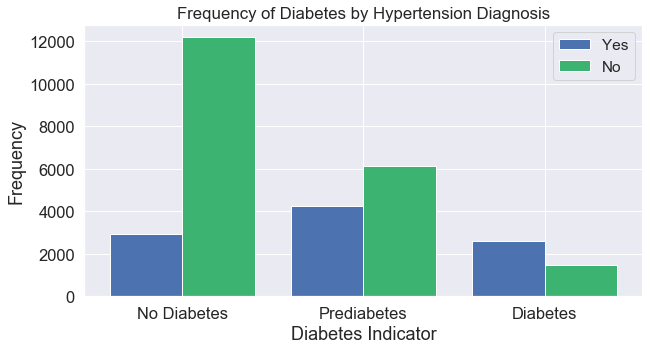

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale=1.4)

yescount = contingency_table_2.iloc[0][0:3].values
nocount = contingency_table_2.iloc[1][0:3].values

categories = ["No Diabetes","Prediabetes","Diabetes"]
x = np.arange(len(categories))

bar_width = 0.4
b1 = ax.bar(x, yescount, 
            width=bar_width, label='Yes')
b2 = ax.bar(x + bar_width, nocount, 
            width=bar_width, label='No', color='mediumseagreen')

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(categories)

# Label the plot.
plt.legend()
ax.set_title('Frequency of Diabetes by Hypertension Diagnosis')
ax.set_xlabel('Diabetes Indicator')
ax.set_ylabel('Frequency')

plt.show()

__Now run the chi-square test.__

In [12]:
f_obs_2 = np.array([contingency_table_2.iloc[0][0:3].values,
                  contingency_table_2.iloc[1][0:3].values])
f_obs_2

array([[ 2942,  4236,  2585],
       [12191,  6126,  1480]], dtype=int64)

In [52]:
chi2, p, dof, expected = stats.chi2_contingency(f_obs_2)
print('chi-square statistic = ',chi2, '\np-value = ', p, '\ndegrees of freedom = ', dof, '\nexpected values = ', expected)

chi-square statistic =  3268.53516616707 
p-value =  0.0 
degrees of freedom =  2 
expected values =  [[ 4998.08792287  3422.33443843  1342.5776387 ]
 [10134.91207713  6939.66556157  2722.4223613 ]]


__Our $\chi^{2}$ value is even larger than before, and our p-value is zero. We have evidence against the null hypothesis, and therefore choose the alternate hypothesis that a hypertension diagnosis and diabetes indicator are related.__

### Test 3:
> __$H_{0}$: There is no statistically significant relationship between moderate activity and diabetes diagnosis.__  
> __$H_{a}$: There is a statistically significant relationship between moderate activity and diabetes diagnosis.__  

In [14]:
activity_diab_test = labs_ques[['PAQ665', 'DIAB']].dropna(how='any')
activity_diab_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32374 entries, 0 to 41442
Data columns (total 2 columns):
PAQ665    32374 non-null float64
DIAB      32374 non-null float64
dtypes: float64(2)
memory usage: 758.8 KB


Moderate Activity: 1=Yes, 2=No, 7=Refused, 9=Don't know; Diabetes Indicator: 0=No Diabetes, 1=Prediabetes, 2=Diabetes

In [15]:
contingency_table_3 = pd.crosstab(
    activity_diab_test['PAQ665'],
    activity_diab_test['DIAB'],
    margins=True, 
    rownames=['Moderate Activity'],
    colnames=['Diabetes Indicator']
)
contingency_table_3

Diabetes Indicator,0.0,1.0,2.0,All
Moderate Activity,,,,
1.0,7937,4231,1227,13395
2.0,9431,6683,2857,18971
9.0,5,0,3,8
All,17373,10914,4087,32374


We only really care about the Yes and No responses for Moderate Activity. We will ignore the Don't know data. With that, this data is also a good fit for a chi-square test. Let's visualize the data before running the chi-square test.

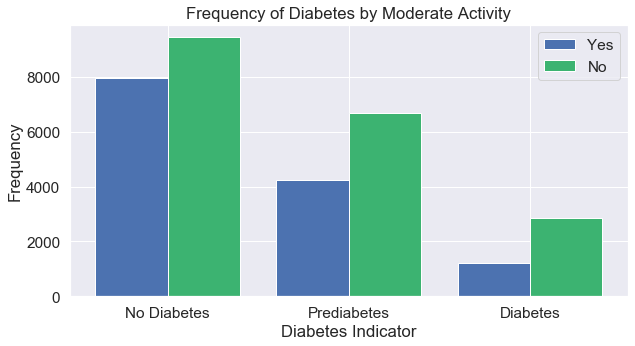

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale=1.4)

yescount = contingency_table_3.iloc[0][0:3].values
nocount = contingency_table_3.iloc[1][0:3].values

categories = ["No Diabetes","Prediabetes","Diabetes"]
x = np.arange(len(categories))

bar_width = 0.4
b1 = ax.bar(x, yescount, 
            width=bar_width, label='Yes')
b2 = ax.bar(x + bar_width, nocount, 
            width=bar_width, label='No', color='mediumseagreen')

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(categories)

# Label the plot.
plt.legend()
ax.set_title('Frequency of Diabetes by Moderate Activity')
ax.set_xlabel('Diabetes Indicator')
ax.set_ylabel('Frequency')

plt.show()

__Now run the chi-square test.__

In [17]:
f_obs_3 = np.array([contingency_table_3.iloc[0][0:3].values,
                  contingency_table_3.iloc[1][0:3].values])
f_obs_3

array([[7937, 4231, 1227],
       [9431, 6683, 2857]], dtype=int64)

In [53]:
chi2, p, dof, expected = stats.chi2_contingency(f_obs_3)
print('chi-square statistic = ',chi2, '\np-value = ', p, '\ndegrees of freedom = ', dof, '\nexpected values = ', expected)

chi-square statistic =  380.623640395496 
p-value =  2.2316528979568528e-83 
degrees of freedom =  2 
expected values =  [[ 7187.92436507  4516.87048137  1690.20515356]
 [10180.07563493  6397.12951863  2393.79484644]]


__Our $\chi^{2}$ value is once again very large, and our p-value is tiny. We have evidence against the null hypothesis, and therefore choose the alternate hypothesis that moderate activity and diabetes indicator are related.__

### Test 4:
> __$H_{0}$: There is no statistically significant relationship between marital status and diabetes diagnosis.__  
> __$H_{a}$: There is a statistically significant relationship between marital status and diabetes diagnosis.__  

In [19]:
mar_diab_test = labs_demo[['DMDMARTL', 'DIAB']].dropna(how='any')
mar_diab_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26746 entries, 0 to 41442
Data columns (total 2 columns):
DMDMARTL    26746 non-null float64
DIAB        26746 non-null float64
dtypes: float64(2)
memory usage: 626.9 KB


Marital Status: 1=Married, 2=Widowed, 3=Divorced, 4=Separated, 5=Never Married, 6=Living with Partner, 77=Refused, 99=Don't know; Combine Married + Living with Partner into one group, all others except Refused and Don't know in second group. Ignore Refused and Don't know answers.  
Diabetes Indicator: 0=No Diabetes, 1=Prediabetes, 2=Diabetes

In [20]:
def set_cohabit(row):
    """
    Return integer indicator for cohabitation based on DMDMARTL column:
    1 = Yes (Married or Living with Partner)
    2 = No (Widowed, Divorded, Separated, Never Married)
    NaN = Any other value (Refused, Don't know)
    """
    
    if row['DMDMARTL'] in [1, 6]:
        return 1
    elif row['DMDMARTL'] in [2, 3, 4, 5]:
        return 2
    else:
        return np.NaN
    
mar_diab_test = mar_diab_test.assign(COHABIT=mar_diab_test.apply(set_cohabit, axis=1))       

In [21]:
contingency_table_4 = pd.crosstab(
    mar_diab_test['COHABIT'],
    mar_diab_test['DIAB'],
    margins=True, 
    rownames=['Marital Status'],
    colnames=['Diabetes Indicator']
)
contingency_table_4

Diabetes Indicator,0.0,1.0,2.0,All
Marital Status,,,,
1.0,7453,6031,2415,15899
2.0,5348,3865,1622,10835
All,12801,9896,4037,26734


This data is also a good fit for a chi-square test. Let's visualize the data before running the chi-square test.

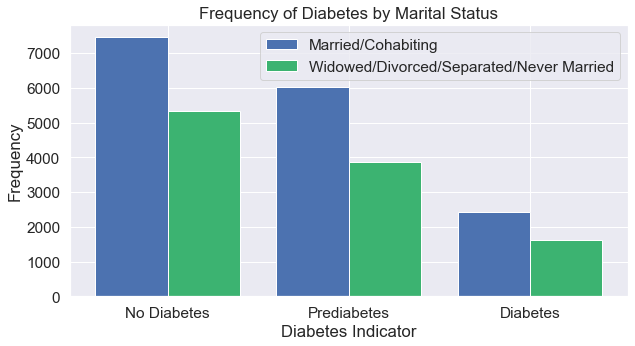

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale=1.4)

yescount = contingency_table_4.iloc[0][0:3].values
nocount = contingency_table_4.iloc[1][0:3].values

categories = ["No Diabetes","Prediabetes","Diabetes"]
x = np.arange(len(categories))

bar_width = 0.4
b1 = ax.bar(x, yescount, 
            width=bar_width, label='Married/Cohabiting')
b2 = ax.bar(x + bar_width, nocount, 
            width=bar_width, label='Widowed/Divorced/Separated/Never Married', color='mediumseagreen')

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(categories)

# Label the plot.
plt.legend()
ax.set_title('Frequency of Diabetes by Marital Status')
ax.set_xlabel('Diabetes Indicator')
ax.set_ylabel('Frequency')

plt.show()

__Now run the chi-square test.__

In [23]:
f_obs_4 = np.array([contingency_table_4.iloc[0][0:3].values,
                  contingency_table_4.iloc[1][0:3].values])
f_obs_4

array([[7453, 6031, 2415],
       [5348, 3865, 1622]], dtype=int64)

In [54]:
chi2, p, dof, expected = stats.chi2_contingency(f_obs_4)
print('chi-square statistic = ',chi2, '\np-value = ', p, '\ndegrees of freedom = ', dof, '\nexpected values = ', expected)

chi-square statistic =  17.396916855369003 
p-value =  0.00016684281310478535 
degrees of freedom =  2 
expected values =  [[7612.89365602 5885.25862198 2400.847722  ]
 [5188.10634398 4010.74137802 1636.152278  ]]


__Our $\chi^{2}$ value is a bit large, and our p-value is small. There is only a .017% chance of getting a test statistic at least this extreme by random chance under the null hypothesis. We thus have evidence against the null hypothesis, and  choose the alternate hypothesis that marital status and diabetes indicator are related.__

## Look at Triglycerides, Systolic blood pressure, BMI, Serum Iron, and AST continuous markers. 

For these continuous markers, we will use the t-test to evaluate our hypotheses. Our underlying data distributions are not normal, but we have large samples so due to the Central Limit Theorem this test is appropriate. 

### Test 5:
> __$H_{0}$: The means of Triglycerides of participants with No Diabetes and Prediabetes indicators are the same.__  
> __$H_{a}$: The means of Triglycerides of participants with No Diabetes and Prediabetes indicators are different.__  

What are our sample sizes?

In [25]:
trig_test = labs[['LBXTR', 'DIAB']].dropna(how='any')
len(trig_test[trig_test['DIAB']==0]['LBXTR']), len(trig_test[trig_test['DIAB']==1]['LBXTR'])

(6284, 6657)

Now let's look at the two distributions. 

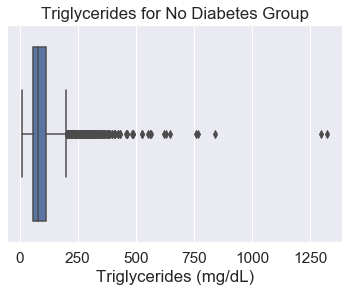

In [56]:
# DIAB = 0 is No Diabetes.
ax = sns.boxplot(trig_test[trig_test['DIAB']==0]['LBXTR'])
ax.set_title('Triglycerides for No Diabetes Group')
ax.set_xlabel('Triglycerides (mg/dL)')
plt.show()

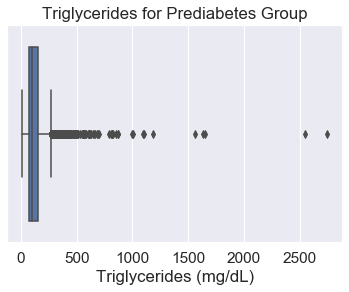

In [27]:
# DIAB = 1 is Prediabetes.
ax = sns.boxplot(trig_test[trig_test['DIAB']==1]['LBXTR'])
ax.set_title('Triglycerides for Prediabetes Group')
ax.set_xlabel('Triglycerides (mg/dL)')
plt.show()

Let's see if the variances are the same. 

In [28]:
nodiab = trig_test[trig_test['DIAB']==0]['LBXTR']
prediab = trig_test[trig_test['DIAB']==1]['LBXTR']
np.var(nodiab, ddof=1), np.var(prediab, ddof=1)

(4268.134205310702, 10133.694096493999)

Variances are definitely different. Now let's calculate t-statistic and probability. 

In [29]:
# Use scipy ttest_ind to perform two tailed test. 
t_value, p_value = stats.ttest_ind(nodiab, prediab, equal_var=False)
t_value, p_value

(-20.9254004609381, 1.8693419763813204e-95)

__The t statistic is far from 0 and the p-value is essentially zero. We can reject our null hypothesis and conclude the means of the No Diabetes group and the Prediabetes group are different.__ 

### Test 6:
> __$H_{0}$: The means of Systolic Blood Pressure of participants with No Diabetes and Prediabetes indicators are the same.__  
> __$H_{a}$: The means of Systolic Blood Pressure of participants with No Diabetes and Prediabetes indicators are different.__  

What are our sample sizes?

In [30]:
exam_labs = exam.merge(labs, on='SEQN')
sys_test = exam_labs[['BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXSY4', 'DIAB']]
sys_test = sys_test.assign(BPXSYM = sys_test[['BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXSY4']].mean(axis=1))
sys_test.dropna(subset=['BPXSYM'], how='any')
len(sys_test[sys_test['DIAB']==0]['BPXSYM']), len(sys_test[sys_test['DIAB']==1]['BPXSYM'])

(17476, 10939)

Now let's look at the two distributions. 

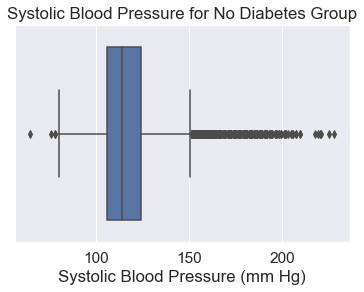

In [31]:
# DIAB = 0 is No Diabetes.
ax = sns.boxplot(sys_test[sys_test['DIAB']==0]['BPXSYM'])
ax.set_title('Systolic Blood Pressure for No Diabetes Group')
ax.set_xlabel('Systolic Blood Pressure (mm Hg)')
plt.show()

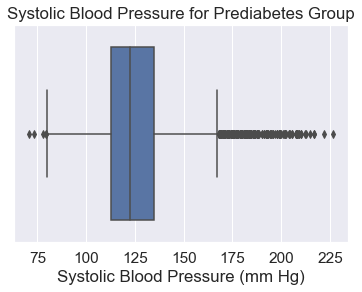

In [32]:
# DIAB = 1 is Prediabetes
ax = sns.boxplot(sys_test[sys_test['DIAB']==1]['BPXSYM'])
ax.set_title('Systolic Blood Pressure for Prediabetes Group')
ax.set_xlabel('Systolic Blood Pressure (mm Hg)')
plt.show()

Let's see if the variances are the same. 

In [33]:
nodiab = sys_test[sys_test['DIAB']==0]['BPXSYM'].dropna()
prediab = sys_test[sys_test['DIAB']==1]['BPXSYM'].dropna()
np.var(nodiab, ddof=1), np.var(prediab, ddof=1)

(252.7158500426021, 331.12948514075805)

Variances are not the same. Now calculate the t statistic and p-value. 

In [34]:
# Use scipy ttest_ind to perform two tailed test. 
t_value, p_value = stats.ttest_ind(nodiab, prediab, equal_var=False)
t_value, p_value

(-40.10197933183673, 0.0)

__Once again, the t statistic is far from 0 and the p-value is 0. We must reject the null hypothesis and conclude the means of the No Diabetes and Prediabetes groups are statistically different.__

### Test 7:
> __$H_{0}$: The means of Body Mass Index (BMI) of participants with No Diabetes and Prediabetes indicators are the same.__  
> __$H_{a}$: The means of BMI of participants with No Diabetes and Prediabetes indicators are different.__  

What are our sample sizes?

In [35]:
exam_labs = exam.merge(labs, on='SEQN')
bmi_test = exam_labs[['BMXBMI', 'DIAB']].dropna(how='any')
len(bmi_test[bmi_test['DIAB']==0]['BMXBMI']), len(bmi_test[bmi_test['DIAB']==1]['BMXBMI'])

(17278, 10832)

Now let's look at the two distributions. 

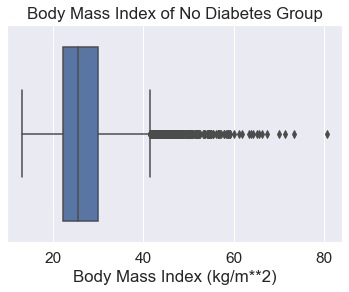

In [36]:
# DIAB = 0 is No Diabetes.
ax = sns.boxplot(bmi_test[bmi_test['DIAB']==0]['BMXBMI'])
ax.set_title('Body Mass Index of No Diabetes Group')
ax.set_xlabel('Body Mass Index (kg/m**2)')
plt.show()

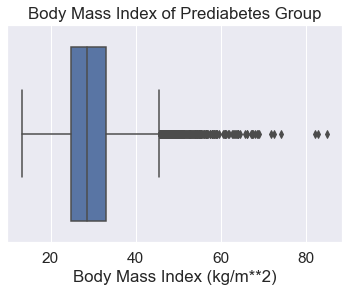

In [37]:
# DIAB = 1 is Prediabetes
ax = sns.boxplot(bmi_test[bmi_test['DIAB']==1]['BMXBMI'])
ax.set_title('Body Mass Index of Prediabetes Group')
ax.set_xlabel('Body Mass Index (kg/m**2)')
plt.show()

Let's see if the variances are the same. 

In [38]:
nodiab = bmi_test[bmi_test['DIAB']==0]['BMXBMI'].dropna()
prediab = bmi_test[bmi_test['DIAB']==1]['BMXBMI'].dropna()
np.var(nodiab, ddof=1), np.var(prediab, ddof=1)

(40.63984573585249, 49.88384222343248)

The variances are closer than the other features we've looked at, but not the same. 

In [39]:
# Use scipy ttest_ind to perform two tailed test. 
t_value, p_value = stats.ttest_ind(nodiab, prediab, equal_var=False)
t_value, p_value

(-35.58996455051064, 1.5896184338313457e-269)

__Once again, the t statistic is far from 0 and the p-value is essentially zero. We reject the null hypothesis and conclude the means of the No Diabetes and Prediabetes groups are different.__

### Test 8:
> __$H_{0}$: The means of Serum Iron of participants with No Diabetes and Prediabetes indicators are the same.__  
> __$H_{a}$: The means of Serum Iron of participants with No Diabetes and Prediabetes indicators are different.__  

What are our sample sizes?

In [40]:
iron_test = labs[['LBXSIR', 'DIAB']]
len(iron_test[iron_test['DIAB']==0]['LBXSIR']), len(iron_test[iron_test['DIAB']==1]['LBXSIR'])

(17476, 10939)

Now let's look at the two distributions. 

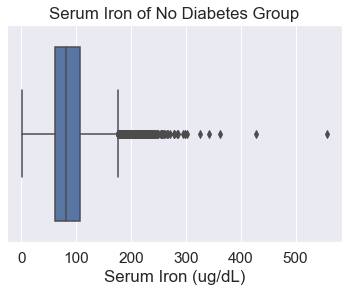

In [41]:
# DIAB = 0 is No Diabetes.

ax = sns.boxplot(iron_test[iron_test['DIAB']==0]['LBXSIR'])
ax.set_title('Serum Iron of No Diabetes Group')
ax.set_xlabel('Serum Iron (ug/dL)')
plt.show()

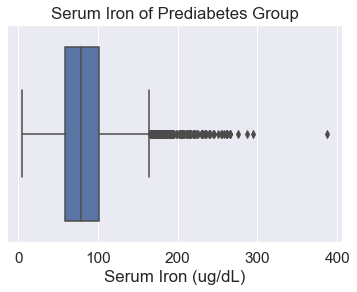

In [42]:
# DIAB = 1 is Prediabetes
ax = sns.boxplot(iron_test[iron_test['DIAB']==1]['LBXSIR'])
ax.set_title('Serum Iron of Prediabetes Group')
ax.set_xlabel('Serum Iron (ug/dL)')
plt.show()

Let's see if the variances are the same. 

In [43]:
nodiab = iron_test[iron_test['DIAB']==0]['LBXSIR'].dropna()
prediab = iron_test[iron_test['DIAB']==1]['LBXSIR'].dropna()
np.var(nodiab, ddof=1), np.var(prediab, ddof=1)

(1399.998749816164, 1156.0330863138986)

Variances are not the same. Let's run the t-test. 

In [44]:
# Use scipy ttest_ind to perform two tailed test. 
t_value, p_value = stats.ttest_ind(nodiab, prediab, equal_var=False)
t_value, p_value

(9.628371452714159, 6.636136369705415e-22)

__These results are less extreme than the others we've looked at, but the t statistic is still far from zero and the p-value is essentially zero. We must reject the null hypothesis and conclude the means of the two groups are different.__

### Test 9:
> __$H_{0}$: The means of Asparate aminotransferase (AST) of participants with No Diabetes and Prediabetes indicators are the same.__  
> __$H_{a}$: The means of AST of participants with No Diabetes and Prediabetes indicators are different.__  

What are our sample sizes?

In [45]:
ast_test = labs[['LBXSASSI', 'DIAB']]
len(ast_test[ast_test['DIAB']==0]['LBXSASSI']), len(ast_test[ast_test['DIAB']==1]['LBXSASSI'])

(17476, 10939)

Now let's look at the two distributions. 

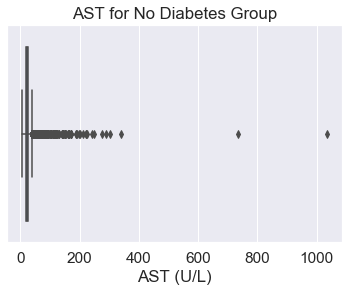

In [46]:
# DIAB = 0 is No Diabetes.

ax = sns.boxplot(ast_test[ast_test['DIAB']==0]['LBXSASSI'])
ax.set_title('AST for No Diabetes Group')
ax.set_xlabel('AST (U/L)')
plt.show()

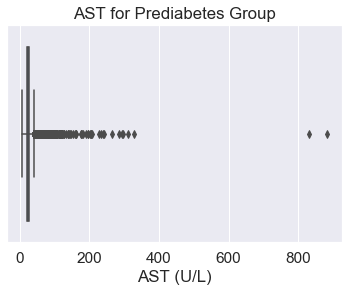

In [47]:
# DIAB = 0 is No Diabetes.
ast_test = labs[['LBXSASSI', 'DIAB']]
ax = sns.boxplot(ast_test[ast_test['DIAB']==1]['LBXSASSI'])
ax.set_title('AST for Prediabetes Group')
ax.set_xlabel('AST (U/L)')
plt.show()

Let's see if the variances are the same. 

In [48]:
nodiab = ast_test[iron_test['DIAB']==0]['LBXSASSI'].dropna()
prediab = ast_test[iron_test['DIAB']==1]['LBXSASSI'].dropna()
np.var(nodiab, ddof=1), np.var(prediab, ddof=1)

(233.59033770556636, 328.6253069851899)

Variances are not the same. Calculate the t statistic. 

In [49]:
# Use scipy ttest_ind to perform two tailed test. 
t_value, p_value = stats.ttest_ind(nodiab, prediab, equal_var=False)
t_value, p_value

(-6.664305052978581, 2.728435547339861e-11)

__Once again, the t statistic is far from zero and p-value is very small. We must reject the null hypothesis and accept the alternate hypothesis that the means of AST are different between the two groups.__

### Let's try bootstrapping and see if we get a similar result. 

In [50]:
# Bootstrap to check difference of means crossing zero to see if we get the same result. Also calculate 95%
#    confidence interval. Specify a random seed so answer will be consistent. 
# Calculate difference in means of bootstrap replicates of prediabetic AST and non-diabetic AST charges. 
n_reps = 10000
np.random.seed(47)
diff_mean_reps = np.empty(n_reps)

nodiab_mean_reps = np.empty(n_reps)
prediab_mean_reps = np.empty(n_reps)

for i in range(n_reps):
    # Create bootstrap replicates for means of no diabetes and prediabetes values. 
    nodiab_mean_reps[i] = np.mean(np.random.choice(nodiab, len(nodiab)))
    prediab_mean_reps[i] = np.mean(np.random.choice(prediab, len(prediab)))
    
# Calculate difference in means. 
diff_mean_reps = prediab_mean_reps - nodiab_mean_reps

# Calculate 95% confidence interval. 
conf_int_low_mean, conf_int_high_mean = np.percentile(diff_mean_reps, [2.5, 97.5])
np.round(conf_int_low_mean, 2), np.round(conf_int_high_mean, 2)

(1.0, 1.81)

__The bootstrap test with 10,000 replicates indicates a 95% chance the prediabetic AST mean is 1.0 - 1.81 U/L higher than the non-diabetic mean.__